# HW4 - MobileNet V1 and V2: A PyTorch Tutorial
[CE40477: Machine Learning](https://www.sharifml.ir/)

__Course Instructor__: Dr. Sharifi-Zarchi

__Notebook Author__: Amirmahdi Meighani



In this notebook, we present a comprehensive guide to understanding and implementing the MobileNet V1 and V2 architectures using PyTorch. MobileNet is a highly regarded family of deep learning architectures, designed by Google with a primary focus on creating models that are both lightweight and computationally efficient. These models are particularly optimized for mobile and embedded devices, where resources like memory, processing power, and battery life are often limited.

MobileNet stands out for its unique design principles, particularly the use of depthwise separable convolutions, which significantly reduce the number of parameters and computation required compared to traditional convolutional neural networks. This makes MobileNet an ideal choice for applications that demand real-time performance, such as mobile apps, IoT devices, and on-device machine learning tasks.

Another application for MobileNet is edge deployment. Its scalable architecture allows customization through width and resolution multipliers, making it adaptable to the resource constraints of various devices. Additionally, MobileNet's low power consumption is ideal for battery-operated systems, and its compatibility with frameworks like TensorFlow Lite and hardware accelerators like Edge TPUs ensures seamless deployment. These features make it perfect for real-time, on-device applications such as object detection, face recognition, and other AI tasks at the edge.

Throughout this notebook, we will delve into both MobileNet V1 and V2 architectures, examining how each version builds on the previous one to enhance both efficiency and accuracy. By implementing these architectures step-by-step in PyTorch, we aim to provide a solid foundation for anyone interested in leveraging MobileNet’s capabilities for mobile and edge computing applications.

### Objectives
- Understand the structure and advantages of MobileNet V1 and V2
- Learn the theory of depthwise separable convolutions and inverted residuals
- Implement and use MobileNet V1 and V2 in PyTorch
- Use transfer learning for better accuracy

__Name__: Yousef Miryousefi

__Student_ID__: 401110642



![architecture](https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fs41598-024-53349-w/MediaObjects/41598_2024_53349_Fig2_HTML.png)

## 1. MobileNet V1

### Theory
MobileNet V1 was designed by Google to create an efficient and lightweight neural network model for mobile and embedded applications. The architecture is built on **depthwise separable convolutions**, which reduce computation cost and model size compared to traditional convolutions.

- **Depthwise Separable Convolution**: A depthwise separable convolution splits a standard convolution into two parts:
  1. **Depthwise Convolution**: This operation applies a single filter to each input channel independently. It significantly reduces computation by processing each channel separately.
  2. **Pointwise Convolution (1x1 Convolution)**: This operation combines the channels outputted by the depthwise convolution by applying a 1x1 filter. It performs a linear combination across the channels, allowing the model to learn interactions between different channels.

To learn more about this convolution you can check this [link](https://medium.com/@zurister/depth-wise-convolution-and-depth-wise-separable-convolution-37346565d4ec)


Compared to traditional convolution, which combines spatial and channel information simultaneously, depthwise separable convolutions drastically reduce the number of computations.

MobileNet V1 also introduces two scaling hyperparameters:
- **Width Multiplier** (α): Scales the number of channels in each layer, allowing you to shrink the model's width (number of channels).
- **Resolution Multiplier** (ρ): Reduces the resolution of the input image, further decreasing computational cost.


Now let's implement a MobileNet from scratch. Start by importing the necessary libraries.

In [1]:
# Importing libraries

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

import torchvision
from torchvision import transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset
from typing import Tuple, List
from torch.optim import Optimizer
from torch.utils.data import DataLoader


Check your device. We recommend using GPU. You can use GPU with google colab.

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

Before starting we want you to have some knowledge about Batch Normalization.

### **Understanding Batch Normalization**

Batch Normalization (BatchNorm) is a technique designed to improve the training of deep neural networks by normalizing the inputs to each layer. It helps address the issue of "internal covariate shift," where the distribution of activations changes as training progresses.

Batch Normalization consists of two main steps: **Normalization** and **Scaling/Shift**.

### 1. **Normalization**

Given a batch of data $X$ with $m$ samples and $n$ features, Batch Normalization first computes the **mean** ($\mu$) and **variance** ($\sigma^2$) for each feature across the batch:

$$
\mu = \frac{1}{m} \sum_{i=1}^{m} x_i, \quad
\sigma^2 = \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu)^2
$$

Each feature is then normalized using:

$$
\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}
$$

where:
- $\epsilon$: A small constant added to avoid division by zero.



### 2. **Scaling and Shifting**

To allow the model to learn the optimal feature representation, the normalized value $\hat{x}_i$ is scaled and shifted using learnable parameters $\gamma$ (scale) and $\beta$ (shift):

$$
y_i = \gamma \hat{x}_i + \beta
$$



### **Complete Formula**

The full Batch Normalization transformation for each feature is:

$$
y_i = \gamma \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta
$$



## **Why Use Batch Normalization?**

1. **Stabilizes Training**: By normalizing inputs, gradients are more stable, which accelerates convergence.
2. **Reduces Dependence on Initialization**: Makes the network less sensitive to weight initialization.
3. **Acts as a Regularizer**: Introduces noise due to batch statistics, helping reduce overfitting.
4. **Improves Generalization**: Often eliminates the need for other regularization techniques like Dropout.



In [3]:
def batch_normalization(x, gamma, beta, epsilon=1e-5):
    mean = np.mean(x, axis=0)
    variance = np.var(x, axis=0)

    x_hat = (x - mean) / np.sqrt(variance + epsilon)

    y = gamma * x_hat + beta

    return y

In [4]:
x = np.array([[1.0, 2.0, 3.0],
              [4.0, 5.0, 6.0],
              [7.0, 8.0, 9.0],
              [10.0, 11.0, 12.0]])

gamma = 1.0
beta = 0.0


normalized = batch_normalization(x, gamma, beta)


print("Original :\n", x)
print("\nNormalized :\n", normalized)

Original :
 [[ 1.  2.  3.]
 [ 4.  5.  6.]
 [ 7.  8.  9.]
 [10. 11. 12.]]

Normalized :
 [[-1.34164019 -1.34164019 -1.34164019]
 [-0.4472134  -0.4472134  -0.4472134 ]
 [ 0.4472134   0.4472134   0.4472134 ]
 [ 1.34164019  1.34164019  1.34164019]]


We need some data for training, testing and validation. in this part we use CIFAR-10 dataset. It is a famous dataset in vision. CIFAR-10 contains 60,000 32x32 images in 10 classes.

> **Note**: MobileNet models perform best on larger image sizes (like 224x224), but CIFAR-10 is used here as a simple example dataset.


In [5]:
# TRANSFORMS

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761]),
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761]),
])


train_set = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=train_transform)

val_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=test_transform)

half_train_size = len(train_set) // 2
train_indices = list(range(half_train_size))
train_subset = Subset(train_set, train_indices)


train_loader = DataLoader(train_subset, batch_size=64, shuffle=False, num_workers=2)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:04<00:00, 35.6MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Explain what we did in transfor train and tranform test:<br/>


In the code, the `train_transform` is used to enhance the training dataset through data augmentation and normalization. This transformation randomly crops and resizes the image to 224×224 pixels with a scaling factor between 50% and 100%, and it horizontally flips the image with a probability of 50%. These augmentations help the model improve its generalization by introducing diversity in the training data. After these modifications, the images are converted to tensors and normalized using predefined mean and standard deviation values for each color channel.

On the other hand, the `test_transform` prepares the validation and test datasets by resizing each image to a fixed size of 224×224 pixels without randomness, ensuring consistency in evaluation. Then, the images are converted to tensors and the same normalization used in `train_transform` is applied. This consistent preprocessing ensures that the model's performance is evaluated on data scaled similarly to the training data, providing accurate and reliable evaluation.



for showing images in this notebook we define a function and use it everywhere. you should test your fucntion for 32 first images of dataset and see how our data augmentation worked. Also print labels to see the format.

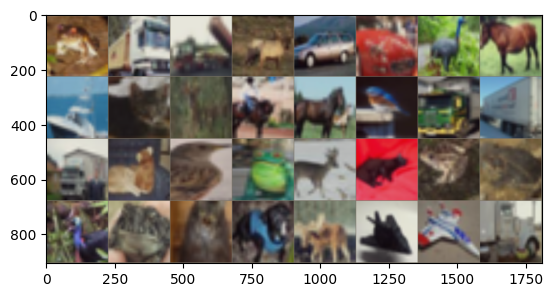


labels are:
 tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6,
        2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2,
        2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2]) 



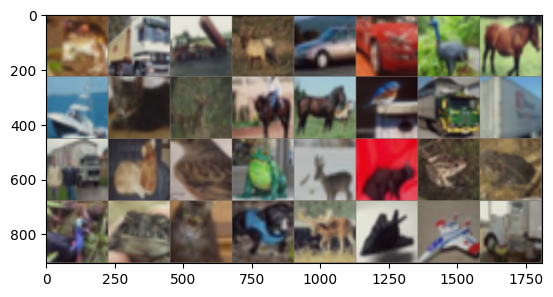

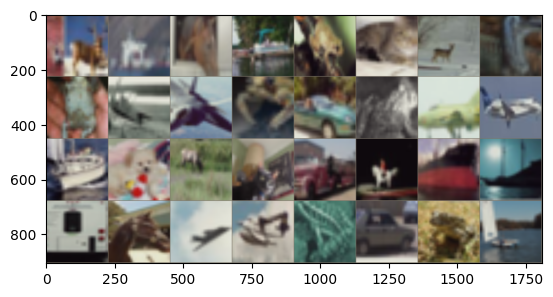

In [6]:
def imshow(img):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img.numpy().transpose((1, 2, 0))
    img = img * std + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:32]))

print("\nlabels are:\n", labels, "\n")


dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:32]))


train_loader_shuffled = DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=2)

dataiter_shuffled = iter(train_loader_shuffled)
images_shuffled, labels_shuffled = next(dataiter_shuffled)
imshow(torchvision.utils.make_grid(images_shuffled[:32]))


For training our models, we first define some functions to make our job easier. fill the functions according to their signature or you can change them according to your needs.

In [7]:
MODEL_SAVE_PATH = './model.pt'


# Assuming global variables 'device' and 'MODEL_SAVE_PATH' are defined elsewhere.

def fit_epoch(
    model: nn.Module,
    data_loader: DataLoader,
    criterion: nn.Module,
    optimizer: Optimizer,
    train_mode: bool = False
) -> List[float]:
    if train_mode:
      model.train()
    else:
      model.eval()

    epoch_losses = []
    running_loss = 0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in tqdm(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        with torch.set_grad_enabled(train_mode):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            if train_mode:
              loss.backward()
              optimizer.step()
            preds = torch.argmax(outputs, 1)

        epoch_losses += [loss.item()]
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    epoch_loss = running_loss / processed_data
    epoch_acc = running_corrects.cpu().numpy() / processed_data

    if train_mode:
      print(f"train_loss: {epoch_loss:0.5f} | train_acc: {epoch_acc:0.5f}")
    else:
      print(f"  val_loss: {epoch_loss:0.5f} |   val_acc: {epoch_acc:0.5f}")

    return epoch_losses



def train(
    train_loader: DataLoader,
    val_loader: DataLoader,
    model: nn.Module,
    epochs: int,
    lr: float = 1e-3
) -> Tuple[List[float], List[float]]:
    all_train_losses, all_val_losses = [], []
    best_val_loss = float('inf')

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in tqdm(range(epochs)):
        print('EPOCH #', epoch+1)
        train_losses = fit_epoch(model, train_loader, criterion, optimizer, train_mode=True)
        val_losses   = fit_epoch(model, val_loader, criterion, optimizer, train_mode=False)

        all_train_losses += train_losses

        val_loss = np.array(val_losses).mean()
        all_val_losses += [val_loss]

        if val_loss < best_val_loss:
          best_val_loss = val_loss
          torch.save(model.state_dict(), MODEL_SAVE_PATH)

    return all_train_losses, all_val_losses



def get_acc(
    model: nn.Module,
    val_loader: DataLoader
) -> float:
    model.eval()
    running_corrects = 0
    processed_data = 0

    with torch.set_grad_enabled(False):
        for inputs, labels in tqdm(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = torch.argmax(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            processed_data += inputs.size(0)

    epoch_acc = running_corrects.cpu().numpy() / processed_data
    return epoch_acc



def plot_losses(
    train_losses: List[float],
    val_losses: List[float],
    c_window: int = 10
) -> None:
    epochs = len(val_losses)
    train_losses_c = np.convolve(np.array(train_losses[:]),
                                np.ones(c_window)/c_window, mode='valid')

    plt.plot(train_losses_c, label='train_losses')
    plt.plot([i*len(train_losses)/epochs for i in range(1, epochs+1)], np.array(val_losses),
            label='val_losess', marker='o', markersize=8)
    plt.legend()
    plt.grid()
    plt.show()

Finally we can start creating the MobileNet model. The architecture is presented here:
![architecture](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-22_at_4.26.15_PM_ko4FqXD.png)

You can see the related paper [here](https://arxiv.org/abs/1704.04861)

for cleaner implementation first complete these functions(Each layer consists of a depthwise separable convolution followed by a ReLU activation. The architecture efficiently reduces computations by using depthwise separable convolutions, making it suitable for mobile and embedded applications.):

In [8]:
def conv_bn(inp, oup, stride):
    return nn.Sequential(
                nn.Conv2d(inp, oup, kernel_size=3, stride=stride, padding=1, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True)
            )

def conv_dw(inp, oup, stride):
    return nn.Sequential(
            nn.Conv2d(inp, inp, kernel_size=3, stride=stride, padding=1, groups=inp, bias=False),
            nn.BatchNorm2d(inp),
            nn.ReLU(inplace=True),

            nn.Conv2d(inp, oup, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(oup),
            nn.ReLU(inplace=True),
        )

Explain how using Depthwise Separable Convolutions helps us in reducing the number of parameters(calculate and compare number of parameters in normal convolution and depthwise convolution) and how it helps us in making the model faster.


### Depthwise Separable Convolutions: Reducing Parameters and Increasing Speed

Using **depthwise separable convolutions** is effective in two main aspects:  
1. **Reducing the number of parameters**  
2. **Increasing the model's speed**

#### Reducing the Number of Parameters

Suppose we have a standard convolutional layer with the following dimensions:  
- **Number of input channels**: 3  
- **Number of output channels**: 6  
- **Kernel size**: 3x3  

**Standard Convolution:**  
Number of parameters = \(C_{\text{out}} \times C_{\text{in}} \times 3 \times 3 = 6 \times 3 \times 3 \times 3 = 162\) parameters  

**Depthwise Separable Convolution:**  
1. **Depthwise convolution:** Each input channel is convolved separately using a 3x3 kernel.  
   \[
   \text{Number of parameters} = C_{\text{in}} \times 3 \times 3 = 3 \times 3 \times 3 = 27
   \]
2. **Pointwise convolution:** A 1x1 convolution is used to combine features across channels.  
   \[
   \text{Number of parameters} = C_{\text{in}} \times C_{\text{out}} \times 1 \times 1 = 3 \times 6 \times 1 \times 1 = 18
   \]

**Total parameters in depthwise separable convolution:**  
\[
27 + 18 = 45 \, \text{parameters}
\]

**Comparison:**  
- Standard convolution: **162 parameters**  
- Depthwise separable convolution: **45 parameters**  
- **Approximately 70% reduction in parameters**  

#### Increasing Model Speed

By reducing the number of parameters:  
1. The number of computational operations decreases, leading to faster processing.  
2. Lower memory usage is achieved for storing weights and features, improving the model's overall efficiency.


Now please create your model.

In [9]:
class MobileNet(nn.Module):
    def __init__(self, n_class=1000):
        super().__init__()
        self.model = nn.Sequential(
            conv_bn(3, 32, 2),
            conv_dw(32, 64, 1),
            conv_dw(64, 128, 2),
            conv_dw(128, 128, 1),
            conv_dw(128, 256, 2),
            conv_dw(256, 256, 1),
            conv_dw(256, 512, 2),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 512, 1),
            conv_dw(512, 1024, 2),
            conv_dw(1024, 1024, 1),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(1024, n_class)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

Let's train your model.(You can increase number of epochs or change lr but your accuracy should be above 65 and calculate training time)

In [10]:
epochs = 15
lr = 1e-3

model = MobileNet(n_class=10).to(device)
train_losses, val_losses = train(train_loader, val_loader, model, epochs, lr)

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH # 1


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 1.62711 | train_acc: 0.40120


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 1.37478 |   val_acc: 0.49000
EPOCH # 2


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 1.27001 | train_acc: 0.54388


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 1.14243 |   val_acc: 0.59410
EPOCH # 3


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 1.08338 | train_acc: 0.61600


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.93153 |   val_acc: 0.67010
EPOCH # 4


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 0.94978 | train_acc: 0.66652


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.90453 |   val_acc: 0.68260
EPOCH # 5


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 0.85372 | train_acc: 0.70040


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.81200 |   val_acc: 0.71790
EPOCH # 6


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 0.75228 | train_acc: 0.73732


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.72700 |   val_acc: 0.75370
EPOCH # 7


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 0.68297 | train_acc: 0.75992


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.63638 |   val_acc: 0.78300
EPOCH # 8


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 0.63975 | train_acc: 0.77564


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.61732 |   val_acc: 0.78730
EPOCH # 9


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 0.59112 | train_acc: 0.79268


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.57715 |   val_acc: 0.80540
EPOCH # 10


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 0.54330 | train_acc: 0.81032


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.57209 |   val_acc: 0.80890
EPOCH # 11


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 0.50867 | train_acc: 0.82348


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.55013 |   val_acc: 0.81410
EPOCH # 12


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 0.47738 | train_acc: 0.83360


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.52635 |   val_acc: 0.82710
EPOCH # 13


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 0.44919 | train_acc: 0.84324


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.52351 |   val_acc: 0.82580
EPOCH # 14


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 0.43447 | train_acc: 0.84808


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.54637 |   val_acc: 0.82320
EPOCH # 15


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 0.39977 | train_acc: 0.85860


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.54024 |   val_acc: 0.82700


Get some metrics and plot your losses.

  0%|          | 0/157 [00:00<?, ?it/s]

Batch_size=128, epochs=15, lr=0.001
Val accuracy = 0.827
Process validation time: 18.1527 s


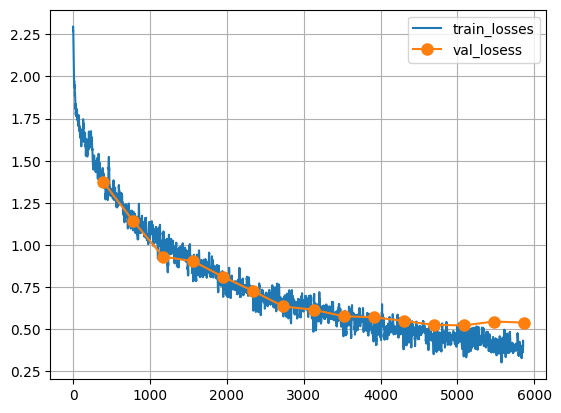

In [11]:
start = time.time()
val_acc = get_acc(model, val_loader)
end = time.time()

print(f'Batch_size={128}, epochs={epochs}, lr={lr}')
print('Val accuracy =', val_acc)
print(f"Process validation time: {(end - start):0.4f} s")

plot_losses(train_losses, val_losses)

The MobileNet paper claims it is 8 to 9 times faster than standard convolution. Using the theoretical computations of FLOPs for standard convolution and depthwise separable convolution, explain how this number was calculated.


### Standard Convolution
For a standard convolution layer with the following parameters:
- **\(C_{in}\)**: Number of input channels
- **\(C_{out}\)**: Number of output channels
- **\(K\)**: Size of the convolution kernel (usually \(3 \times 3\))
- **\(H \times W\)**: Dimensions of the feature map

**The number of FLOPs** is given by:
$$\text{FLOPs}_{\text{Standard}} = C_{out} \times C_{in} \times K \times K \times H \times W$$

---

### Depthwise Separable Convolution
This type of convolution is divided into two stages:

1. **Depthwise Convolution**:
   $$\text{FLOPs}_{\text{Depthwise}} = C_{in} \times K \times K \times H \times W$$

2. **Pointwise Convolution**:
   $$\text{FLOPs}_{\text{Pointwise}} = C_{in} \times C_{out} \times 1 \times 1 \times H \times W$$

**The total number of FLOPs** for depthwise separable convolution is:
$$\text{FLOPs}_{\text{Depthwise Separable}} = C_{in} \times K \times K \times H \times W + C_{in} \times C_{out} \times H \times W$$

---

### Comparison and Reduction of FLOPs
Assume:
- **\(C_{in} = C_{out} = C\)**
- **\(K = 3\)**

**FLOPs for standard convolution:**
$$\text{FLOPs}_{\text{Standard}} = C \times C \times 3 \times 3 \times H \times W = 9C^2HW$$

**FLOPs for depthwise separable convolution:**
$$\text{FLOPs}_{\text{Depthwise Separable}} = C \times 3 \times 3 \times H \times W + C \times C \times H \times W = 9CHW + C^2HW$$

If \( C \) is large, the second term dominates, but in comparison to standard convolution:
$$\frac{\text{FLOPs}_{\text{Standard}}}{\text{FLOPs}_{\text{Depthwise Separable}}} = \frac{9C^2HW}{C^2HW + 9CHW} \approx 9$$




## 2.Normal CNN
In this part, we will give you a new architecture that is like MobileNet. But this time we will use normal CNN. The model is implemented and you should train it for 2 epochs. So now you can compare its speed in training and validating with your MobileNet.(Note that the accuracy is not important in this part)

In [12]:
class NormalCNN(nn.Module):
    def __init__(self, n_class=1000):
        super().__init__()


        self.model = nn.Sequential(
            conv_bn(  3,  32, 2),
            conv_bn( 32,  64, 1),
            conv_bn( 64, 128, 2),
            conv_bn(128, 128, 1),
            conv_bn(128, 256, 2),
            conv_bn(256, 256, 1),
            conv_bn(256, 512, 2),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 1024, 2),
            conv_bn(1024, 1024, 1),
            nn.AvgPool2d(7),
        )
        self.fc = nn.Linear(1024, n_class)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

In [13]:
model = NormalCNN(n_class=10).to(device)
train_cnn_losses, val_cnn_losses = train(train_loader, val_loader, model, 2, lr)

  0%|          | 0/2 [00:00<?, ?it/s]

EPOCH # 1


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 1.93338 | train_acc: 0.26448


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 1.82499 |   val_acc: 0.33460
EPOCH # 2


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 1.70076 | train_acc: 0.36248


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 1.70515 |   val_acc: 0.39570


  0%|          | 0/157 [00:00<?, ?it/s]

Batch_size=128, epochs=15, lr=0.001
Val accuracy = 0.3957
Process validation time: 19.3916 s



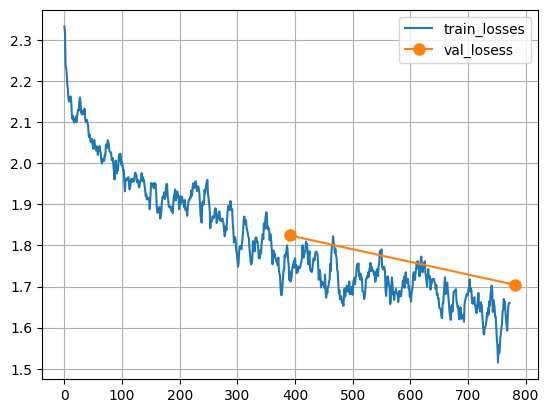

In [14]:
start = time.time()
val_acc = get_acc(model, val_loader)
end = time.time()

print(f'Batch_size={128}, epochs={epochs}, lr={lr}')
print('Val accuracy =', val_acc)
print(f"Process validation time: {(end - start):0.4f} s\n")

plot_losses(train_cnn_losses, val_cnn_losses)

Compare speed of learning and validating in normal CNN vs MobileNet

**Each epoch for MobileNet took 90 seconds, while for CNN it took around 150 seconds.**  
For validation, both took approximately 20 seconds, with CNN taking slightly longer, but the difference is not significant.


In [15]:
# TODO: compare number of parameters in these two models
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

normal_cnn = NormalCNN(n_class=10).to(device)
mobilenet = MobileNet(n_class=10).to(device)

normal_cnn_params = count_parameters(normal_cnn)
mobilenet_params = count_parameters(mobilenet)

print(f"Total number of Normal CNN parameters: {normal_cnn_params}")
print(f"Total number of MobileNet parameters: {mobilenet_params}")

Total number of Normal CNN parameters: 28279338
Total number of MobileNet parameters: 3217226


## 3.Transfer Learning
Now imagine that you have a well trained model of CIFAR10 and now you want to use transfer learning for a new task of classifying CIFAR100 dataset. in the next cell, you should load your good trained model with an accuracy of 80% on validation data from disk (you should have saved your good model). or use our model (model.pt) and use their parameters for a new model for classifying 100 classes.

In [16]:
model = MobileNet(n_class=100).to(device)


pretrained_dict = torch.load(MODEL_SAVE_PATH, map_location=device)


model_dict = model.state_dict()
filtered_dict = {k: v for k, v in pretrained_dict.items()
                 if k in model_dict and v.shape == model_dict[k].shape and 'fc' not in k}


model_dict.update(filtered_dict)
model.load_state_dict(model_dict, strict=False)

<ipython-input-16-a6865965ff08>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load(MODEL_SAVE_PATH, map_location=device)


<All keys matched successfully>

**Freezing Layers** </br>
To make the best use of transfer learning, you should freeze the initial layers (usually up to the last few convolutional blocks) and only fine-tune the final layers. This way, the model retains most of the learned low-level features from CIFAR-10, while also adapting to CIFAR-100.

In MobileNet, it’s generally effective to freeze layers up to the point where the most complex, high-level features are computed, typically around the 7th or 8th convolutional block.

In [17]:
def freeze_layers(model, freeze_until=7):
    for i, child in enumerate(model.model.children()):
        if i < freeze_until:
            for param in child.parameters():
                param.requires_grad = False


freeze_layers(model, freeze_until=7)

**Fine-tuning the Model** </br>

With the above setup, you can now train the model on CIFAR-100 using a lower learning rate. A good approach would be to:

Set a slightly lower learning rate (e.g., 1e-4) for the fine-tuning process.

But first get the dataset of CIFAR100.

In [18]:
train_set100 = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=train_transform)

indices = np.arange(20000)
train_set100 = Subset(train_set100, indices)

train_loader100 = torch.utils.data.DataLoader(
    train_set100, batch_size=128, shuffle=False, num_workers=2)

val_set100 = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=test_transform)

val_loader100 = torch.utils.data.DataLoader(
    val_set100, batch_size=128, shuffle=False, num_workers=2)

100%|██████████| 169M/169M [00:03<00:00, 44.0MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


Now show 16 images of your data two times to see the images and how our data augmentaion worked. Also print labels to see the format.

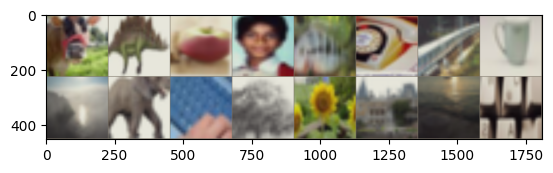


labels are:
 tensor([19, 29,  0, 11,  1, 86, 90, 28, 23, 31, 39, 96, 82, 17, 71, 39,  8, 97,
        80, 71, 74, 59, 70, 87, 59, 84, 64, 52, 42, 64,  8, 17, 47, 65, 21, 22,
        81, 11, 24, 84, 78, 45, 49, 97, 56, 76, 11, 90, 89, 78, 73, 14, 87,  9,
        71,  6, 47, 20, 98, 47, 36, 55, 72, 43, 51, 35, 83, 33, 27, 53, 92, 50,
        15, 89, 36, 18, 89, 46, 33, 42, 39, 64, 75, 38, 23, 42, 66, 77, 49, 18,
        46, 15, 35, 69, 95, 83, 75, 99, 73, 93, 55, 39,  4, 97, 61, 93, 51, 69,
        56, 84, 59, 64, 94,  4, 11, 33, 68, 38, 20, 33, 34, 32, 46, 53, 88, 67,
        70, 64])


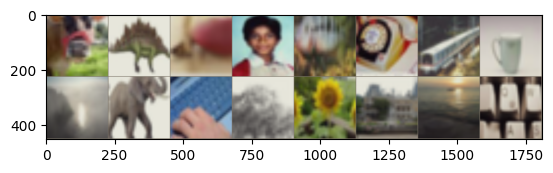

In [19]:
dataiter = iter(train_loader100)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:16]))

print("\nlabels are:\n", labels)


dataiter = iter(train_loader100)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:16]))

Do CIFAR10 and CIFAR100 use the same images but with diffrent labesl?(maybe you should search)


The CIFAR10 and CIFAR100 datasets are separate from each other and have different images and labels. Both contain 60,000 color images with dimensions of 32x32 pixels, but CIFAR10 has 10 classes, each containing 6,000 images, while CIFAR100 has 100 classes, each containing 600 images. The images in these two datasets are assigned separately, and none of the images from CIFAR10 are used directly in CIFAR100, and vice versa.

Now train your model using your functions.

In [20]:
epochs = 10
lr = 2e-4
train_losses, val_losses = train(train_loader100, val_loader100, model, epochs, lr)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH # 1


  0%|          | 0/157 [00:00<?, ?it/s]

train_loss: 4.35701 | train_acc: 0.04135


  0%|          | 0/79 [00:00<?, ?it/s]

  val_loss: 4.12468 |   val_acc: 0.05880
EPOCH # 2


  0%|          | 0/157 [00:00<?, ?it/s]

train_loss: 3.94349 | train_acc: 0.09255


  0%|          | 0/79 [00:00<?, ?it/s]

  val_loss: 3.86688 |   val_acc: 0.09710
EPOCH # 3


  0%|          | 0/157 [00:00<?, ?it/s]

train_loss: 3.70933 | train_acc: 0.12950


  0%|          | 0/79 [00:00<?, ?it/s]

  val_loss: 3.69149 |   val_acc: 0.12680
EPOCH # 4


  0%|          | 0/157 [00:00<?, ?it/s]

train_loss: 3.53186 | train_acc: 0.15810


  0%|          | 0/79 [00:00<?, ?it/s]

  val_loss: 3.58593 |   val_acc: 0.15120
EPOCH # 5


  0%|          | 0/157 [00:00<?, ?it/s]

train_loss: 3.39614 | train_acc: 0.18705


  0%|          | 0/79 [00:00<?, ?it/s]

  val_loss: 3.41545 |   val_acc: 0.17940
EPOCH # 6


  0%|          | 0/157 [00:00<?, ?it/s]

train_loss: 3.28294 | train_acc: 0.20730


  0%|          | 0/79 [00:00<?, ?it/s]

  val_loss: 3.30689 |   val_acc: 0.19700
EPOCH # 7


  0%|          | 0/157 [00:00<?, ?it/s]

train_loss: 3.18340 | train_acc: 0.22290


  0%|          | 0/79 [00:00<?, ?it/s]

  val_loss: 3.27434 |   val_acc: 0.21110
EPOCH # 8


  0%|          | 0/157 [00:00<?, ?it/s]

train_loss: 3.10013 | train_acc: 0.23600


  0%|          | 0/79 [00:00<?, ?it/s]

  val_loss: 3.17888 |   val_acc: 0.23010
EPOCH # 9


  0%|          | 0/157 [00:00<?, ?it/s]

train_loss: 3.02099 | train_acc: 0.25210


  0%|          | 0/79 [00:00<?, ?it/s]

  val_loss: 3.16762 |   val_acc: 0.22900
EPOCH # 10


  0%|          | 0/157 [00:00<?, ?it/s]

train_loss: 2.95242 | train_acc: 0.26615


  0%|          | 0/79 [00:00<?, ?it/s]

  val_loss: 3.10801 |   val_acc: 0.23910


Get some metrics and plot your losses.

  0%|          | 0/79 [00:00<?, ?it/s]

Batch_size=128, epochs=10, lr=0.0002
Val accuracy = 0.2391
Process validation time: 17.7803 s



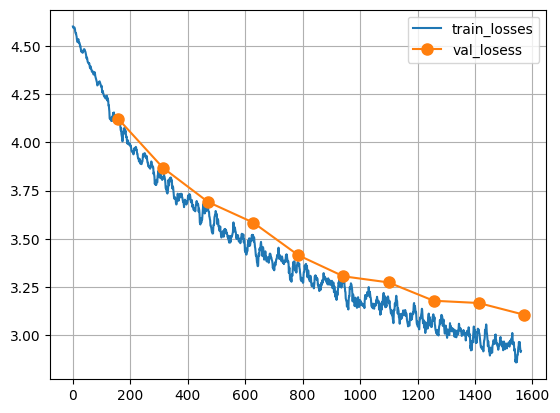

In [21]:
start = time.time()
val_acc = get_acc(model, val_loader100)
end = time.time()

print(f'Batch_size={128}, epochs={epochs}, lr={lr}')
print('Val accuracy =', val_acc)
print(f"Process validation time: {(end - start):0.4f} s\n")

plot_losses(train_losses, val_losses)

## 4. MobileNet V2

### Theory
MobileNet V2 builds on the concepts of MobileNet V1, introducing two significant improvements:


- **Inverted Residuals**: One of the most notable features of MobileNet V2 is the use of inverted residual blocks. Unlike traditional residual blocks that connect layers of the same depth, inverted residuals connect layers with different depths, allowing for more efficient information flow and reducing computational complexity.
- **Linear Bottlenecks**: MobileNet V2 introduces linear bottlenecks between the layers. These bottlenecks help preserve the information by maintaining low-dimensional representations, which minimizes information loss and improves the overall accuracy of the model.
- **Depthwise Separable Convolutions**: Similar to MobileNet V1, MobileNet V2 employs depthwise separable convolutions to reduce the number of parameters and computations. This technique splits the convolution into two separate operations: depthwise convolution and pointwise convolution, significantly reducing computational cost.
- **ReLU6 Activation Function**: MobileNet V2 uses the ReLU6 activation function, which clips the ReLU output at 6. This helps prevent numerical instability in low-precision computations, making the model more suitable for mobile and embedded devices.

These innovations enable MobileNet V2 to achieve better accuracy with minimal increase in complexity, making it highly suitable for mobile applications.

You can learn more about MobileNetv2 [here](https://arxiv.org/abs/1801.04381).

One of the paper’s major contributions is the linear bottleneck. In deep learning, especially in low-dimensional spaces, using non-linear layers like ReLU after compressing data can cause important information to be lost. MobileNetV2 addresses this by using linear layers instead of ReLU in the bottleneck stages.


![lb](https://miro.medium.com/v2/resize:fit:720/format:webp/1*YGVXczC3hYtey2z-9MBkPw.png)


Another key innovation in MobileNetV2 is the inverted residual block. Unlike traditional residual blocks (such as those used in ResNet), which expand first and then compress, inverted residuals do the opposite. In MobileNetV2, the input is first compressed and then expanded back to the original dimensions.

![irb](https://miro.medium.com/v2/resize:fit:640/format:webp/1*KyvQcI3Z8AxPpxjLpzrRdg.png)

As shown above, the inverted residual block (b) uses shortcuts, similar to those used in ResNet, but it compresses first and expands second, which makes it more efficient. This “inversion” allows for significant improvements in efficiency by reducing the number of operations required. To maintain performance, shortcuts (or skip connections) are used between the bottleneck layers, ensuring smooth gradient flow during training and preventing the loss of important information.

Now where are going to implement the model. First complete the below functions and class.

What is ReLU6 Activation Function? Why do we use that?

The ReLU6 function is a modified version of ReLU, where its output is restricted between 0 and 6. This function is defined as the minimum of the standard ReLU function and 6. By reducing numerical errors and limiting activation values, it provides greater stability during training and inference, making it more optimized for hardware environments.


In [22]:
def conv_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernel_size=3, stride=stride, padding=1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )

def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernel_size=1, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )

class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        self.use_res_connect = self.stride == 1 and inp == oup
        hidden_dim = inp * expand_ratio

        layers = []
        if expand_ratio != 1:
          layers.append(conv_1x1_bn(inp, hidden_dim))

        layers.append(nn.Sequential(
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=stride, padding=1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True)
        ))

        layers.append(nn.Sequential(
            nn.Conv2d(hidden_dim, oup, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(oup)
        ))

        self.conv = nn.Sequential(*layers)


    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

Now create the model using the image below. Please note that you should have the width_multiplier hyperparameter in your model. we will use it later.

![architecture](https://i.sstatic.net/1RAkv.png)

In [23]:
class MobileNetV2(nn.Module):
    def __init__(self, n_class=1000, input_size=224, width_multiplier=1.0):
        super(MobileNetV2, self).__init__()
        inverted_residual_setting = [
              [1, 16, 1, 1],
              [6, 24, 2, 2],
              [6, 32, 3, 2],
              [6, 64, 4, 2],
              [6, 96, 3, 1],
              [6, 160, 3, 2],
              [6, 320, 1, 1]
        ]

        input_channel = int(32 * width_multiplier)
        self.last_channel = int(1280 * width_multiplier) if width_multiplier > 1.0 else 1280
        self.features = [conv_bn(3, input_channel, stride=2)]


        for t, c, n, s in inverted_residual_setting:
            output_channel = int(c * width_multiplier)
            for i in range(n):
                stride = s if i == 0 else 1
                self.features.append(InvertedResidual(inp=input_channel, oup=output_channel, stride=stride, expand_ratio=t))
                input_channel = output_channel

        self.features.append(conv_1x1_bn(input_channel, self.last_channel))
        self.features = nn.Sequential(*self.features)

        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.last_channel, n_class)
        )


        self._initialize_weights()


    def forward(self, x):
        x = self.features(x)
        x = x.mean([2, 3])
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

How did you create linear bottlenecks? How do they help?


It consists of three main stages: increasing dimensions with a 1x1 pointwise convolution, applying depthwise convolution, and reducing dimensions again with a 1x1 pointwise convolution without nonlinear activation. This structure allows the number of channels to be increased initially and then returned to the original number, resulting in a reduction in the number of parameters and computations.

The advantages of using a linear Bottleneck include a significant reduction in the number of parameters and computational operations, making the model lighter and faster. Furthermore, this approach helps preserve information along the data flow since nonlinear activation is only applied during the dimension-increasing stage, and it is omitted in the dimension-reducing stage. Additionally, the use of residual connections in these blocks ensures better gradient flow, preventing issues like vanishing gradients in deep networks.


Train your model with CIFAR10 dataset. Set the width_multiplier with value 1.

In [24]:
model = MobileNetV2(n_class=10, width_multiplier=1.0).to(device)
epochs = 15
lr = 1e-3
train_losses, val_losses = train(train_loader, val_loader, model, epochs, lr)

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH # 1


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 1.67435 | train_acc: 0.37684


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 1.62676 |   val_acc: 0.43720
EPOCH # 2


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 1.31439 | train_acc: 0.52896


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 1.25939 |   val_acc: 0.56870
EPOCH # 3


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 1.15286 | train_acc: 0.59072


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 1.02852 |   val_acc: 0.63380
EPOCH # 4


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 1.03455 | train_acc: 0.63268


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 1.04778 |   val_acc: 0.64760
EPOCH # 5


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 0.93211 | train_acc: 0.67072


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.92739 |   val_acc: 0.68460
EPOCH # 6


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 0.84131 | train_acc: 0.70360


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.85494 |   val_acc: 0.71340
EPOCH # 7


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 0.76902 | train_acc: 0.73084


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.72820 |   val_acc: 0.75240
EPOCH # 8


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 0.72239 | train_acc: 0.74876


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.69577 |   val_acc: 0.76800
EPOCH # 9


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 0.67350 | train_acc: 0.76704


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.65137 |   val_acc: 0.77660
EPOCH # 10


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 0.63959 | train_acc: 0.77980


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.67960 |   val_acc: 0.77110
EPOCH # 11


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 0.60940 | train_acc: 0.78952


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.59368 |   val_acc: 0.79850
EPOCH # 12


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 0.57064 | train_acc: 0.80424


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.60068 |   val_acc: 0.79580
EPOCH # 13


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 0.54199 | train_acc: 0.81236


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.57902 |   val_acc: 0.80850
EPOCH # 14


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 0.51345 | train_acc: 0.82176


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.55212 |   val_acc: 0.81250
EPOCH # 15


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 0.50074 | train_acc: 0.82708


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.55533 |   val_acc: 0.81480


Get some metrics and plot your losses.

  0%|          | 0/157 [00:00<?, ?it/s]

Batch_size=128, epochs=15, lr=0.001
Val accuracy = 0.8148
Process validation time: 18.6917 s



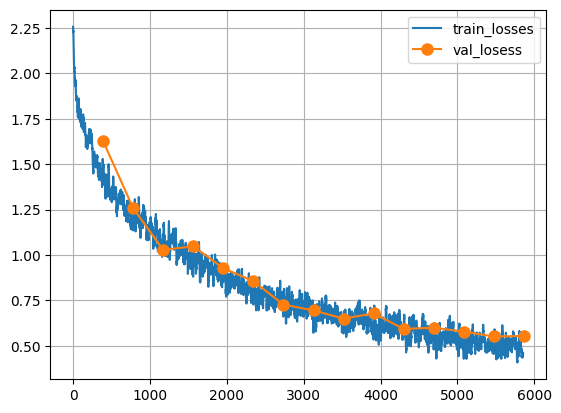

In [26]:
start = time.time()
val_acc = get_acc(model, val_loader)
end = time.time()

print(f'Batch_size={128}, epochs={epochs}, lr={lr}')
print('Val accuracy =', val_acc)
print(f"Process validation time: {(end - start):0.4f} s\n")

plot_losses(train_losses, val_losses)

Now we want to see the effect of the hyperparameter (width multiplier) in our model. For all values between 0.1 to 1 with step 0.1 print the number of parameters.

In [27]:
width_multipliers = [round(x * 0.1, 1) for x in range(1, 11)]

print("Width Multiplier\tNumber of Parameters")
print("-----------------------------------------")

for wm in width_multipliers:
    model = MobileNetV2(n_class=10, width_multiplier=wm)
    num_params = count_parameters(model)
    print(f"{wm}\t\t\t{num_params}")

Width Multiplier	Number of Parameters
-----------------------------------------
0.1			81943
0.2			183048
0.3			318444
0.4			487958
0.5			697258
0.6			931391
0.7			1203792
0.8			1510396
0.9			1851206
1.0			2236682


Now load the pretrained model that we trained with width_multiplier=1/2 for 15 epoches. then compare it's accuracy and time it needs for validation data with normal MobileNetv2 model.

In [28]:
MNv2_path = './model.pt'
model = MobileNetV2(n_class=10, width_multiplier=0.5).to(device)


model_state = model.state_dict()

state_dict = torch.load(MNv2_path)

for key in state_dict:
    if key in model_state and state_dict[key].size() == model_state[key].size():
        model_state[key] = state_dict[key]

model.load_state_dict(model_state)


train_losses, val_losses = train(train_loader, val_loader, model, 15, 1e-3)

<ipython-input-28-d0b01144388f>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(MNv2_path)


  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH # 1


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 1.80453 | train_acc: 0.32752


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 1.55111 |   val_acc: 0.42320
EPOCH # 2


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 1.51641 | train_acc: 0.45148


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 1.32930 |   val_acc: 0.51320
EPOCH # 3


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 1.32515 | train_acc: 0.52632


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 1.19960 |   val_acc: 0.56750
EPOCH # 4


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 1.16840 | train_acc: 0.58292


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 1.07623 |   val_acc: 0.61860
EPOCH # 5


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 1.07394 | train_acc: 0.62188


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.94986 |   val_acc: 0.66790
EPOCH # 6


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 0.98758 | train_acc: 0.65372


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.89600 |   val_acc: 0.68230
EPOCH # 7


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 0.91420 | train_acc: 0.67964


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.87106 |   val_acc: 0.69950
EPOCH # 8


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 0.85536 | train_acc: 0.69972


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.81930 |   val_acc: 0.71780
EPOCH # 9


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 0.81366 | train_acc: 0.71576


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.76748 |   val_acc: 0.73680
EPOCH # 10


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 0.75661 | train_acc: 0.73204


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.71453 |   val_acc: 0.75440
EPOCH # 11


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 0.71350 | train_acc: 0.75144


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.72714 |   val_acc: 0.75550
EPOCH # 12


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 0.67831 | train_acc: 0.76636


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.68237 |   val_acc: 0.77050
EPOCH # 13


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 0.65380 | train_acc: 0.76976


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.64502 |   val_acc: 0.78160
EPOCH # 14


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 0.63111 | train_acc: 0.77664


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.65427 |   val_acc: 0.77580
EPOCH # 15


  0%|          | 0/391 [00:00<?, ?it/s]

train_loss: 0.60401 | train_acc: 0.78896


  0%|          | 0/157 [00:00<?, ?it/s]

  val_loss: 0.65920 |   val_acc: 0.78010


In [29]:
start = time.time()
val_acc = get_acc(model, val_loader)
end = time.time()

print('Val accuracy =', val_acc)
print(f"Process validation time: {(end - start):0.4f} s")

  0%|          | 0/157 [00:00<?, ?it/s]

Val accuracy = 0.7801
Process validation time: 19.9011 s


Explain how this hyperparameter changes the number of parameters in theory. Write a formula to predict its effect without actually creating the models. Compare your formula with the above numbers and if they dont match perfectly explain a bit.

---

The width coefficient (alpha) scales the number of input and output channels for each layer, and thus the number of parameters changes. The number of parameters for a convolutional layer is calculated as follows:

$$
P = k^2 \cdot C_{\text{in}} \cdot C_{\text{out}}
$$

With the application of the width coefficient, this value changes as follows:

$$
P_\alpha = \alpha^2 \cdot k^2 \cdot C_{\text{in}} \cdot C_{\text{out}} = \alpha^2 \cdot P
$$

The theoretical number of parameters is given by:

$$
P_{0.5} = (0.5)^2 \cdot 2,236,682 = 559,171
$$

However, the actual number is \( 697,258 \). This difference occurs for the following reasons:

1. **Bias coefficients:** Each layer has bias parameters in the amount of \( C_{\text{out}} \).
2. **Fixed layers:** Some layers, such as the classification layer, are not affected by alpha.
3. **Depthwise separable convolutions:** These convolutions depend on alpha rather than alpha squared.

These factors lead to an increase in the number of parameters compared to the theoretical value.



Another hyperparameter is resolution multiplier. Can it make our model faster? Does it decrease the number of parameters? Explain.

---

**Resolution coefficient** reduces the input image size and spatial dimensions, impacting the computational cost of the model.

Reducing the input resolution directly decreases the number of FLOPs:

$$
\text{FLOPs} = k^2 \cdot C_{\text{in}} \cdot C_{\text{out}} \cdot H \cdot W
$$

As the resolution decreases, both \(H\) and \(W\) reduce, which increases the speed of the model.

The resolution coefficient does not affect the number of parameters, as parameters depend only on the number of input and output channels, kernel size, and bias, not on the spatial dimensions.


Why is the number of parameters important for us? Now we have GPUs that can increase performance considerably. Is the number of parameters really a big deal?

---

The number of parameters remains important despite advancements in graphics cards. Parameters occupy the GPU memory, and large models can exceed memory limits, especially when training with high-resolution inputs or large data batches. This issue is particularly important for deploying models on devices with limited resources, such as mobile phones.

Increasing the number of parameters also raises inference time, which can be a challenge in real-time applications like voice assistants or autonomous driving. Additionally, larger models consume more energy, making them less suitable where efficiency is critical to reduce costs and environmental impact.

Training larger models requires more time and resources, increasing costs, especially with the need for frequent tuning. While GPUs mitigate some of these challenges, optimizing the number of parameters is still essential for scalability, deployment on various hardware, and maintaining low latency in practical applications.


## 5.Knowledge Distillation

Now we learn how you can implement knowledge distillation using a pre-trained ResNet as the teacher model and MobileNetV2 as the student model for the CIFAR-10 dataset.

Knowledge distillation is a process where a smaller, more efficient model (the student) is trained to replicate the behavior of a larger, more complex model (the teacher). This is particularly useful for deploying models on resource-constrained devices where efficiency and speed are critical.

You can learn more about the loss function we use for this porpuse [here](
https://medium.com/@aryamaanthakur/knowledge-distillation-make-your-neural-networks-smaller-398485f811c6)

First create our teacher.(Pay attention that we need to finetune this teacher for out task, but because of lack of resources we will just use it with terrible accuracy)

In [30]:
import timm

teacher_model = timm.create_model('resnet18', pretrained=True, num_classes=10)
teacher_model = teacher_model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [31]:
start = time.time()
val_acc = get_acc(teacher_model, val_loader)
end = time.time()

print('Val accuracy =', val_acc)
print(f"Process validation time: {(end - start):0.4f} s")


  0%|          | 0/157 [00:00<?, ?it/s]

Val accuracy = 0.0872
Process validation time: 18.1362 s


Now create a mobilenetv2 model and then write the code to train it with Knowledge Distillation.

In [32]:
class DistillationLoss(nn.Module):
    def __init__(self, temperature: float = 3.0, alpha: float = 0.5):
        super(DistillationLoss, self).__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.kl_div_loss = nn.KLDivLoss(reduction='batchmean')
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self,
                student_logits: torch.Tensor,
                teacher_logits: torch.Tensor,
                labels: torch.Tensor) -> torch.Tensor:
        T = self.temperature
        student_logits_scaled = student_logits / T
        teacher_logits_scaled = teacher_logits / T

        student_soft = F.log_softmax(student_logits_scaled, dim=1)
        teacher_soft = F.softmax(teacher_logits_scaled, dim=1)

        kl_loss = self.kl_div_loss(student_soft, teacher_soft) * (T ** 2)

        ce_loss = self.ce_loss(student_logits, labels)

        loss = self.alpha * kl_loss + (1. - self.alpha) * ce_loss
        return loss


def train_student(teacher: nn.Module,
                  student: nn.Module,
                  train_loader: torch.utils.data.DataLoader,
                  test_loader: torch.utils.data.DataLoader,
                  device: torch.device,
                  epochs: int = 10,
                  lr: float = 0.01) -> None:
    teacher.to(device).eval()
    student.to(device)

    criterion = DistillationLoss(temperature=3.0, alpha=0.5)
    optimizer = optim.Adam(student.parameters(), lr=lr)

    for epoch in range(epochs + 1):
        student.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} - Training", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.no_grad():
                teacher_logits = teacher(inputs)

            student_logits = student(inputs)

            loss = criterion(student_logits, teacher_logits, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(student_logits, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = correct / total

        student.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc=f"Epoch {epoch}/{epochs} - Evaluation", leave=False):
                inputs, labels = inputs.to(device), labels.to(device)

                teacher_logits = teacher(inputs)
                student_logits = student(inputs)

                loss = criterion(student_logits, teacher_logits, labels)
                test_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(student_logits, 1)
                test_correct += (predicted == labels).sum().item()
                test_total += labels.size(0)

        test_epoch_loss = test_loss / test_total
        test_epoch_acc = test_correct / test_total

        print(f"Epoch [{epoch}/{epochs}] "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} "
              f"Test Loss: {test_epoch_loss:.4f}, Test Acc: {test_epoch_acc:.4f}")

Train it for one epoch to just check if it works.

In [33]:
student = MobileNetV2(n_class=10)

train_student(teacher_model, student, train_loader, val_loader, device, epochs=1, lr=0.001)

Epoch 0/1 - Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 0/1 - Evaluation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [0/1] Train Loss: 1.0125, Train Acc: 0.3712 Test Loss: 1.0004, Test Acc: 0.4327


Epoch 1/1 - Training:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/1 - Evaluation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [1/1] Train Loss: 0.9058, Train Acc: 0.5217 Test Loss: 0.9088, Test Acc: 0.5329


What are the potential trade-offs of using a high value of alpha (e.g., 0.9) versus a low value of alpha (e.g., 0.1) in the DistillationLoss? How might these trade-offs impact the student model's performance in terms of generalization to the target task and alignment with the teacher's knowledge?

Using a high alpha (such as 0.9) emphasizes the distillation loss and drives the student model to closely mimic the teacher's behavior and leverage its knowledge, which can improve generalization and alignment with the teacher. However, this approach may neglect direct supervision of the true labels and pose the risk of underfitting the target task.

In contrast, a low alpha prioritizes the cross-entropy loss with true labels, focusing more on the target task, but it might ignore the teacher's broad knowledge and limit generalization. Therefore, choosing the right alpha requires a balance between alignment with the teacher and focusing on the target task's objectives.


## Summary
- **MobileNet V1**: Introduced depthwise separable convolutions, significantly reducing computation and model size.
- **MobileNet V2**: Added inverted residuals and linear bottlenecks to improve efficiency and performance, reducing memory use without sacrificing accuracy.

These architectures are optimized for mobile and embedded applications, providing a balance between accuracy and efficiency through lightweight, effective design.

question for yourself: What new features and innovations did MobileNetV3 introduce to improve both efficiency and accuracy over its predecessors? Explore its design choices and how they further optimize MobileNet for real-time applications and mobile deployment.

## Refrences

[1] Andrew G. Howard, Menglong Zhu, Bo Chen,
Dmitry Kalenichenko, Weijun Wang, Tobias
Weyand, Marco Andreetto, and Hartwig Adam. Mobilenets: Efficient convolutional neural networks for mobile vision applications. CoRR,
abs/1704.04861, 2017

[2] Mark Sandler, Andrew G. Howard, Menglong Zhu, Andrey
Zhmoginov, and Liang-Chieh Chen. Mobilenetv2: Inverted
residuals and linear bottlenecks. mobile networks for classification, detection and segmentation. CoRR, abs/1801.04381,
2018